In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np 

plt.rcParams["figure.figsize"] = [10, 7]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

data = pd.read_pickle('./data/scenario_4_search.p')
data.head()

data['vacancy (for rent)'] = data['vacancy (for rent)'] * 100
data['vacancy (for sale)'] = data['vacancy (for sale)'] * 100
data['vacancy (off market)'] = data['vacancy (off market)'] * 100
data['vacancy total'] = data['vacancy total'] * 100
data['tax_rate_vacancy'] = data['tax_rate_vacancy'] * 100


In [2]:
corr = np.corrcoef(data['household_units_to_sample'], data['vacancy total'])
corr_ = corr[0][1]


In [3]:
data[['vacancy (for rent)', 'vacancy (for sale)', 'vacancy (off market)', 'vacancy total']].describe().round(decimals=3)


vacancy (for rent)  vacancy (for sale)  vacancy (off market)  \
count             220.000             220.000               220.000   
mean                0.077              17.649                 4.354   
std                 0.236               1.474                 1.009   
min                 0.000              14.004                 2.156   
25%                 0.000              16.657                 3.575   
50%                 0.000              17.597                 4.367   
75%                 0.000              18.753                 5.067   
max                 1.198              21.153                 7.352   

       vacancy total  
count        220.000  
mean          22.080  
std            0.798  
min           19.403  
25%           21.642  
50%           22.093  
75%           22.572  
max           24.765

 
-0.07569 x + 22.84


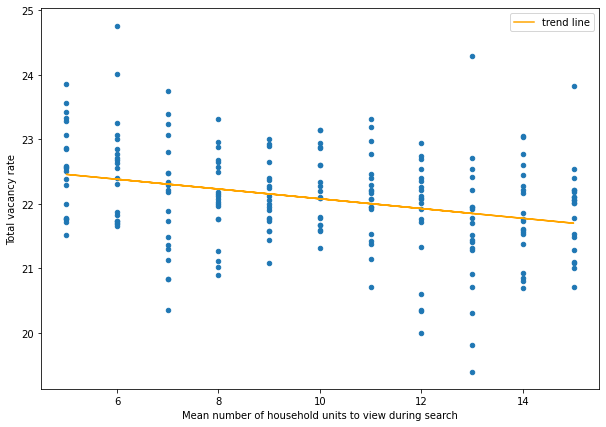

In [4]:
data.plot.scatter(x='household_units_to_sample', y='vacancy total', legend=True)

trend = np.polyfit(data['household_units_to_sample'], data['vacancy total'], 1)

trend_line = np.poly1d(trend)
print(trend_line)
plt.plot(data['household_units_to_sample'], trend_line(data['household_units_to_sample']), label='trend line', color='orange')

#plt.axhline(y=23, c='r', label='Initial vacancy rate')
plt.xlabel('Mean number of household units to view during search')
plt.ylabel('Total vacancy rate')
plt.legend()


Text(0, 0.5, 'Total vacancy rate (%)')

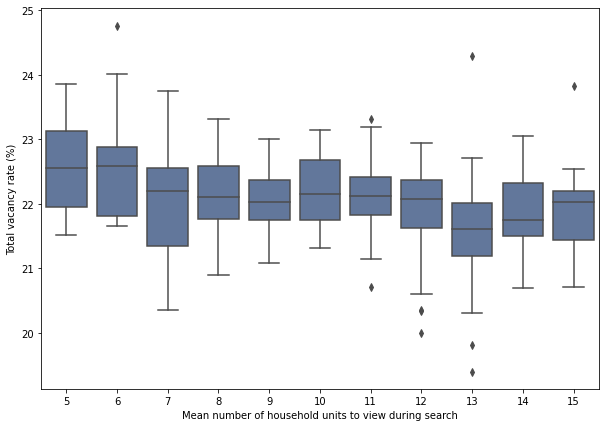

In [5]:
import seaborn as sns

ax = sns.boxplot(x='household_units_to_sample', y='vacancy total', data=data, color='#5975a4')

plt.xlabel('Mean number of household units to view during search')
plt.ylabel('Total vacancy rate (%)')


(4.5, 15.4)

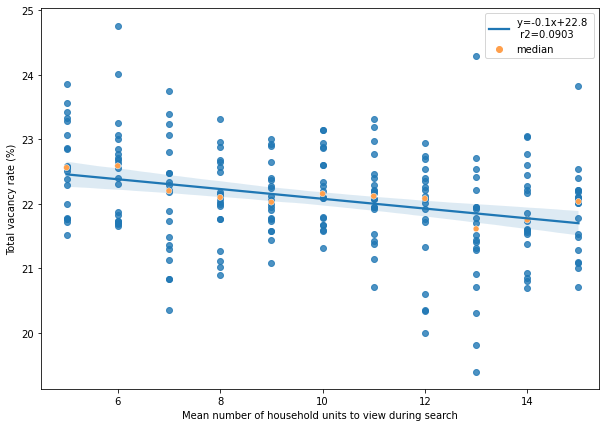

In [6]:
ax = sns.regplot(x='household_units_to_sample', y='vacancy total', data=data, line_kws={'label': 'y={1:.1f}x+{2:.1f} \n r2={0:.4f}'.format(corr_**2, *trend_line.coeffs)})

medians = data.groupby(['household_units_to_sample'])[['vacancy total']].apply(np.median)
med_df = pd.DataFrame(medians)
med_df.rename(columns = {0:'median'}, inplace = True) 
med_df.head()
sns.scatterplot(data=med_df, palette=['#ff9f4b'])

plt.xlabel('Mean number of household units to view during search')
plt.ylabel('Total vacancy rate (%)')
plt.legend()
plt.xlim(4.5, 15.4)

Text(0.5, 0, 'Vacancy rate (%)')

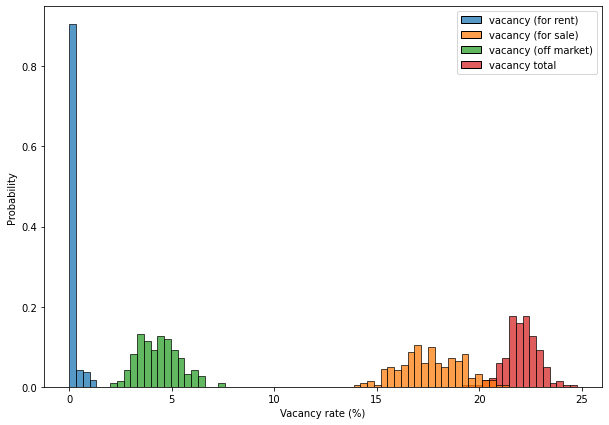

In [7]:
vacancy_df = data[['vacancy (for rent)', 'vacancy (for sale)', 'vacancy (off market)', 'vacancy total']]

vacancy_df.head()

sns.histplot(data=vacancy_df, bins=75, common_norm=False, stat='probability')

plt.xlabel('Vacancy rate (%)')
#plt.ylabel('Count')


In [8]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

from model import BSRIModel

from mesa.batchrunner import BatchRunner
from agents.investor import InvestorAgent


fixed_params = {
    "tax_rate_property": 0.01,
    "tax_rate_transfer": 0.01,
    "file": '../../neighbourhoods_clean.geojson',
    "new_households_per_1k_units_per_step": 9.5,
    "central_bank_interest_rate": 0.1,
#    "household_units_to_sample": 10,
    "tax_rate_property_vacant": 0.0,
    "tax_rate_vacancy": 0.02,
}
                                      
variable_params = {
    "household_units_to_sample": [6, 14],
}


model_reporters={
    "rental transactions": lambda model: model.transaction_count_rent_cumulative,
    "sale transactions": lambda model: model.transaction_count_sale_cumulative,
    "rentals": lambda model:  model.datacollector.get_table_dataframe('rentals'),
    "sales": lambda model:  model.datacollector.get_table_dataframe('sales'),
    "unhoused tenants": lambda model: len(model.households_without_homes),
    "vacancy total": lambda model: len(model.vacancies)/model.n_housing_units, 
    "vacancy (off market)": lambda model: len([unit for unit in model.vacancies if unit.on_market == 'no' and isinstance(unit.owner, InvestorAgent)])/model.n_housing_units, 
    "vacancy (for sale)": lambda model: len([unit for unit in model.vacancies if unit.on_market == 'sale'])/model.n_housing_units, 
    "vacancy (for rent)": lambda model: len([unit for unit in model.vacancies if unit.on_market == 'rent'])/model.n_housing_units, 
    "arrivals": lambda model: model.datacollector.get_table_dataframe('arrivals'), 
    "residents": lambda model: model.datacollector.get_table_dataframe('residents'), 
    "departures": lambda model: model.datacollector.get_table_dataframe('departures'), 
    "housing unit ownership": lambda model: model.datacollector.get_table_dataframe('housing unit ownership'),
    "neighbourhoods": lambda model: model.datacollector.get_table_dataframe('neighbourhoods')
}


batch_run = BatchRunner(BSRIModel,
                        variable_parameters=variable_params,
                        fixed_parameters=fixed_params,
                        iterations=1,
                        max_steps=20,
                        model_reporters=model_reporters)
batch_run.run_all()

0it [00:00, ?it/s]

>>>>> initialized with 5427 housing units


1it [00:44, 44.08s/it]

>>>>> -------------- SIMULATION COMPLETE AFTER 20 STEPS
>>>>> initialized with 5427 housing units


2it [01:26, 43.34s/it]

>>>>> -------------- SIMULATION COMPLETE AFTER 20 STEPS


In [9]:
data = batch_run.get_model_vars_dataframe()
data.head()

run_0 = data.iloc[0]
run_2 = data.iloc[1]

ownership_0 = gpd.GeoDataFrame(run_0['housing unit ownership'])
ownership_2 = gpd.GeoDataFrame(run_2['housing unit ownership'])


neighbourhoods_0 = gpd.GeoDataFrame(run_0['neighbourhoods'])
neighbourhoods_2 = gpd.GeoDataFrame(run_2['neighbourhoods'])

In [10]:
neighbourhoods_0['vacancy rate'] = neighbourhoods_0['vacancy rate'] * 100
neighbourhoods_2['vacancy rate'] = neighbourhoods_2['vacancy rate'] * 100


In [11]:
ownership_2.describe()

step      unit id         area            x            y  \
count  5427.0  5427.000000  5427.000000  5427.000000  5427.000000   
mean     20.0  2787.000000   114.275659    46.381979    52.582458   
std       0.0  1566.784286    40.139619    23.182250    21.441861   
min      20.0    74.000000    58.000000     0.000000     0.000000   
25%      20.0  1430.500000    87.000000    28.000000    36.000000   
50%      20.0  2787.000000    97.000000    46.000000    54.000000   
75%      20.0  4143.500000   137.000000    64.000000    70.000000   
max      20.0  5500.000000   249.000000    99.000000    98.000000   

        investor id   price rent    price sale  price sale init  \
count   1650.000000  5427.000000  5.427000e+03     5.427000e+03   
mean   10770.276970  1960.982548  4.829404e+05     4.805032e+05   
std     1649.071992  1550.543746  3.886676e+05     3.765755e+05   
min     9122.000000   488.800000  1.235000e+05     1.222000e+05   
25%     9595.250000   972.330000  2.412290e+05     2.419335e+05   
50%    10062.000000  1294.128000  3.181440e+05     3.196090e+05   
75%    12788.750000  2439.652000  6.018505e+05     6.036480e+05   
max    14065.000000  8617.120413  2.600065e+06     2.031500e+06   

       price rent init   rent delta   sale delta  
count      5427.000000  5427.000000  5427.000000  
mean       1922.012876     3.165939    -0.109718  
std        1506.301909    33.884113     5.965958  
min         488.800000   -45.588235   -56.527594  
25%         967.734000     0.000000     0.000000  
50%        1278.436000     0.000000     0.000000  
75%        2414.592000     0.000000     0.000000  
max        8126.000000   640.476267    83.783784

In [12]:
boundaries = gpd.read_file('../../neighbourhoods_clean.geojson')


fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# add titles
axs[0, 0].set_title('average of 6 units to view while searching')
axs[0, 1].set_title('average of 14 units to view while searching')

## with 0% vacancy tax
ownership_0.plot(column='rent delta', 
                 ax=axs[0, 0],
                 legend=False,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Rent price change (%)",},
                 vmin=-60,
                 vmax=60,
)

ownership_0.plot(column='sale delta', 
                 ax=axs[1, 0],
                 legend=False,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Sale price change (%)",},
                 vmin=-50,
                 vmax=50,
)
neighbourhoods_0.plot(column='vacancy rate',
                      ax=axs[2, 0],
                      legend=False,
                      cmap='RdBu_r', 
                      legend_kwds={'label': "Vacancy rate (%)",},
                      vmin=0,
                      vmax=50,
)


### with 2% vacancy tax
ownership_2.plot(column='rent delta', 
                 ax=axs[0, 1],
                 legend=True,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Rent price change (%)",},
                 vmin=-60,
                 vmax=60,
)

ownership_2.plot(column='sale delta', 
                 ax=axs[1, 1],
                 legend=True,
                 cmap='RdBu_r', 
                 marker='o',
                 markersize=12,
                 legend_kwds={'label': "Sale price change (%)",},
                 vmin=-50,
                 vmax=50,
)
neighbourhoods_2.plot(column='vacancy rate',
                      ax=axs[2, 1],
                      legend=True,
                      cmap='RdBu_r', 
                      legend_kwds={'label': "Vacancy rate (%)",},
                      vmin=0,
                      vmax=50,
)

for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(frame_on=False)
        boundaries.plot(ax=ax, facecolor="none", edgecolor="#808080")
